## Image Classification Using Deep Features

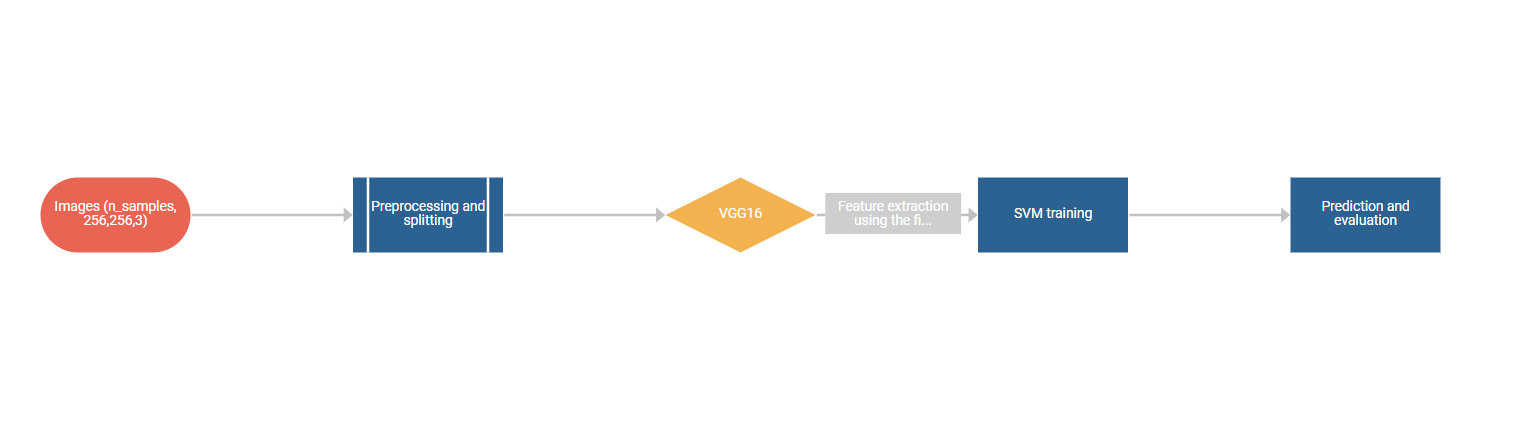

In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


### Dataset Import and preprocessiong

In [2]:
data_dir =  r"UCMerced_LandUse\UCMerced_LandUse\Images" 

classes = sorted(os.listdir(data_dir)) 
image_size = (256, 256)  
num_classes = len(classes)


images = []
labels = []

for idx, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    image_files = sorted(os.listdir(class_dir))
    
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        img = cv2.imread(image_path)
        img = cv2.resize(img, image_size)  
        images.append(img)
        labels.append(idx) 

In [3]:
classes

['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']

In [4]:
images = np.array(images)
labels = np.array(labels)

In [5]:
labels

array([ 0,  0,  0, ..., 20, 20, 20])

### Dataset Splitting: with ensurance that the split mainains a balance of images from different categories

In [6]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    indices = np.arange(len(X))
    np.random.shuffle(indices)
    

    test_size = int(len(X) * test_size)
    train_size = len(X) - test_size
    
    X_train = X[indices[:train_size]]
    X_test = X[indices[train_size:]]
    y_train = y[indices[:train_size]]
    y_test = y[indices[train_size:]]
    
    return X_train, X_test, y_train, y_test


In [7]:

X_train, X_test = [], []
y_train, y_test = [], []
for class_idx in range(num_classes):
    class_images = images[labels == class_idx]
    class_labels = labels[labels == class_idx]
    
    X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
        class_images, class_labels, test_size=0.2, random_state=42
    )
    
    X_train.extend(X_train_cls)
    y_train.extend(y_train_cls)
    X_test.extend(X_test_cls)
    y_test.extend(y_test_cls)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set: X={X_test.shape}, y={y_test.shape}")



Training set: X=(1680, 256, 256, 3), y=(1680,)
Testing set: X=(420, 256, 256, 3), y=(420,)


In [19]:
from keras.applications.vgg16 import preprocess_input
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")

def resize_images(images, target_size=(224, 224)):
    resized_images = np.array([cv2.resize(img, target_size) for img in images])
    return resized_images

X_train_resized = resize_images(X_train)
X_test_resized = resize_images(X_test)

X_train_preprocessed = preprocess_input(X_train_resized)
X_test_preprocessed = preprocess_input(X_test_resized)

print("Images resized and preprocessed successfully.")

Train set size: 1680, Test set size: 420
Images resized and preprocessed successfully.


In [25]:
X_train_preprocessed.shape
X_test_preprocessed.shape


(420, 224, 224, 3)

### Deep feature extraction

##### 1- Load VGG16 model without the final classification layer.

In [17]:
from keras.applications import VGG16
from keras.models import Model

vgg16_model = VGG16(weights='imagenet', include_top=True)

feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('fc2').output)

print("VGG16 model loaded successfully. Using fc2 layer for feature extraction.")

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2545s 5us/step
VGG16 model loaded successfully. Using fc2 layer for feature extraction.


In [20]:

X_train_features = feature_extractor.predict(X_train_preprocessed)
X_test_features = feature_extractor.predict(X_test_preprocessed)

print(f"Training features extracted: {X_train_features.shape}")
print(f"Testing features extracted: {X_test_features.shape}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
Training features extracted: (1680, 4096)
Testing features extracted: (420, 4096)


### SVM classifier training

In [21]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=42))

svm_classifier.fit(X_train_features, y_train)

print("SVM Classifier trained successfully.")




SVM Classifier trained successfully.


In [22]:
y_pred = svm_classifier.predict(X_test_features)

print(f"Predicted labels: {y_pred}")


Predicted labels: [ 0  1 13 12  4  9  9  2  1 11  9  6 17  6  1  3  4 18 18 17 17  5 13 10
 20  1  4 11  0 15 10 20  5 15  6 18 10 17 15  9 20  2 16  7 17  2  0  2
  4 20 13  2  0 16  7 10 13  4 18 12 20 19  6 18 12 11 14 15 17 13 19  8
 16  1 17  9 17 11  8 17 18  8 16  1 19 19  5 11 12 17  1 14 14  2  5 19
 16 11  0  1  4 11  2 20 16 11 18  0 10 19 10  4 16  2 13  8 18  8 15 20
 12  3 20 17  2 16 13 14  1  4 18 15  8 20  5 19  9  4 17 19 11  1 18 13
  4  9 20  6 17 13  4 13  1 11 12  6  1  7 15  9  1 16  8  2  2 19  4  1
 12  2 14  8  2 14 17 18  7 17 20 11 16 14  3 18 17  8 15  2  4  0  1  6
 11  9  3 16  6 14 14 18 15 12 19  4 15 18 11 17 12 20  3 16 13 18  6 19
 12 18 19 17  3  6 14 14  7 13 12 17  9  6  6 13 14 14 12 20 12 14 13 15
 16 13 18 20 20 16 19  7  4 10 19  5  6  5 18 11 12 17 11 11  5 10  5 12
 16  7 20 14 11 17 18  0 10  5 12  7  8 15 17 14  8 15 18 10  2  3  7  8
  3  7 19 12 10 17 13 20  4  6 17  9 15  7 18  6  0  8 17 15  4  5 10 10
  9  7 18  2  1 10  0 10  2 15 17

### 4. Performance Evaluation
Compute Accuracy and Confusion Matrix

Accuracy: 92.62%


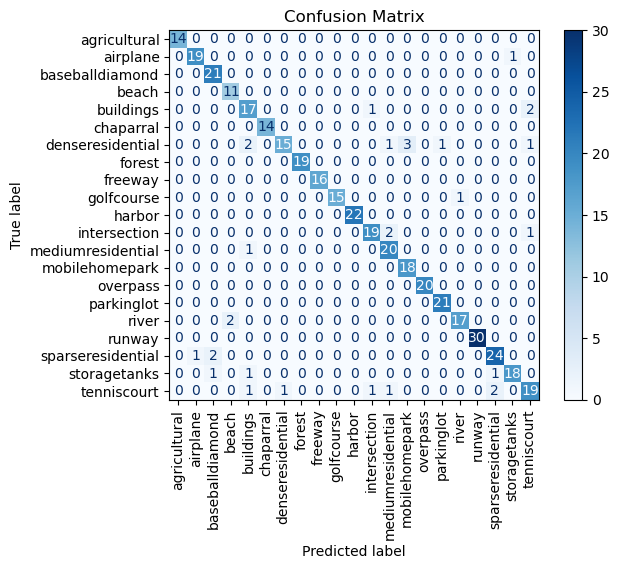

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()
